## Install dependencies

Uncomment and run the following cell to install the required dependencies.

In [1]:
!export LC_ALL=C.UTF-8
!export LANG=C.UTF-8

In [2]:
!pip install -U geemap segment-geospatial groundingdino-py leafmap localtileserver pycrs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 8.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70

In [1]:
import leafmap
import geemap
import ee
from samgeo import SamGeo
from samgeo.text_sam import LangSAM

In [2]:
import ee
ee.Authenticate()


In [3]:
# Authenticating and Initializing Google Earth Engine
ee.Authenticate()
ee.Initialize(project='my-project-hack-451802')

## Create an interactive map

In [5]:
m = geemap.Map()
point = ee.Geometry.Point(-122.259679, 37.871838)
collection = (
    ee.ImageCollection("USDA/NAIP/DOQQ")
    .filterBounds(point)
    .filterDate("2008-01-01", "2018-01-01")
    .filter(ee.Filter.listContains("system:band_names", "N"))
)
image = collection.first()
m.add_layer(image, {}, "NAIP")
m.center_object(point, 19)
m

Map(center=[37.87183799999999, -122.259679], controls=(WidgetControl(options=['position', 'transparent_bg'], w…

## Download a sample image


In [7]:
bbox = m.user_roi_coords()
if bbox is None:
    bbox = [-122.2666, 37.8682, -122.252, 37.8752]

In [8]:
geemap.ee_to_geotiff(
    image, "naip.tif", bbox, zoom=17, vis_params={"bands": ["R", "G", "B"]}
)

Downloaded image 1/30
Downloaded image 2/30
Downloaded image 3/30
Downloaded image 4/30
Downloaded image 5/30
Downloaded image 6/30
Downloaded image 7/30
Downloaded image 8/30
Downloaded image 9/30
Downloaded image 10/30
Downloaded image 11/30
Downloaded image 12/30
Downloaded image 13/30
Downloaded image 14/30
Downloaded image 15/30
Downloaded image 16/30
Downloaded image 17/30
Downloaded image 18/30
Downloaded image 19/30
Downloaded image 20/30
Downloaded image 21/30
Downloaded image 22/30
Downloaded image 23/30
Downloaded image 24/30
Downloaded image 25/30
Downloaded image 26/30
Downloaded image 27/30
Downloaded image 28/30
Downloaded image 29/30
Downloaded image 30/30
Saving GeoTIFF. Please wait...
Image saved to naip.tif


In [9]:
sam = SamGeo(
    model_type="vit_h",
    device=None,
    sam_kwargs=None,
)

In [10]:
sam.generate("naip.tif", output="masks.tif", foreground=True, unique=True)

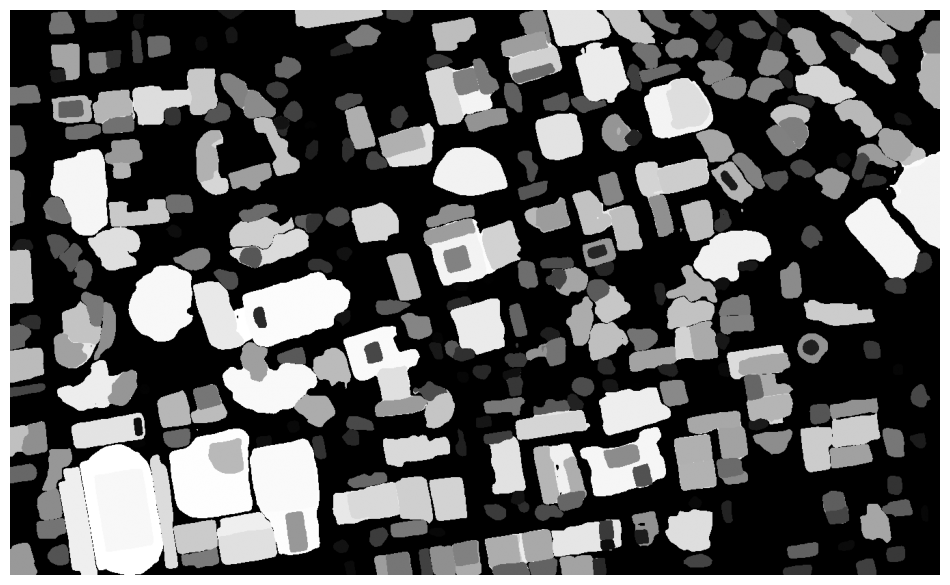

In [11]:
sam.show_masks(cmap="binary_r")

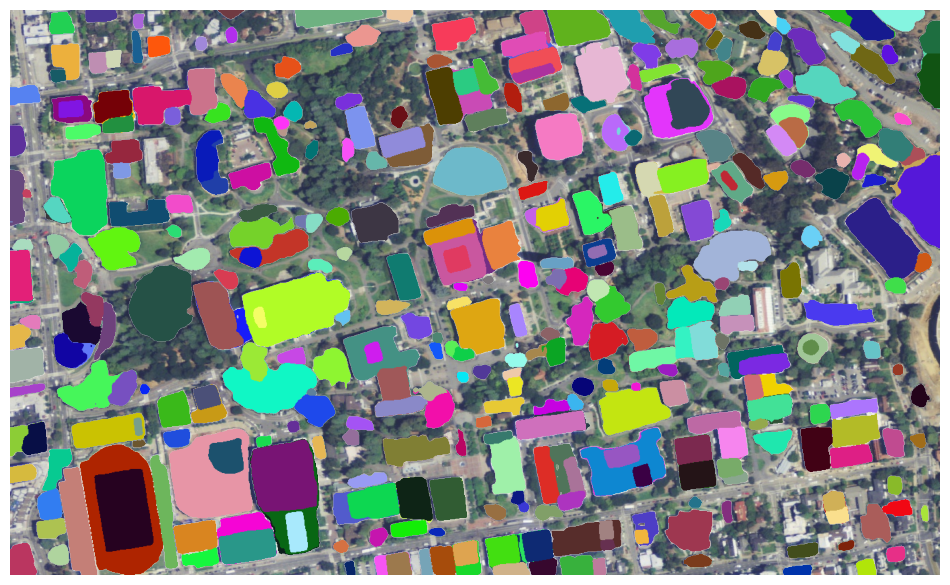

In [12]:
sam.show_anns(axis="off", alpha=1, output="annotations.tif")

In [14]:
sam.tiff_to_vector("masks.tif", "masks.shp")

In [15]:
style = {
    "color": "#3388ff",
    "weight": 2,
    "fillColor": "#7c4185",
    "fillOpacity": 0.5,
}
m.add_vector("masks.shp", layer_name="Vector", style=style)
m

Map(center=[37.87183799999999, -122.259679], controls=(WidgetControl(options=['position', 'transparent_bg'], w…

Google Earth Engine with Prompt-Based Segmentation

In [55]:
m = geemap.Map()
point = ee.Geometry.Point(-122.259679, 37.871838)
collection = (
    ee.ImageCollection("USDA/NAIP/DOQQ")
    .filterBounds(point)
    .filterDate("2008-01-01", "2018-01-01")
    .filter(ee.Filter.listContains("system:band_names", "N"))
)
image = collection.first()
m.add_layer(image, {}, "NAIP")
m.center_object(point, 16)
m

Map(center=[37.87183799999999, -122.259679], controls=(WidgetControl(options=['position', 'transparent_bg'], w…

In [56]:
# Get the bounding box from user selection or set a default bbox
bbox = m.user_roi_coords()
if bbox is None:
    bbox = [-122.2666, 37.8682, -122.252, 37.8752]

In [57]:
output_image = "naip_prompt.tif"
geemap.ee_to_geotiff(
    image, output_image, bbox, zoom=16, vis_params={"bands": ["R", "G", "B"]}
)


Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to naip_prompt.tif


In [58]:
# Load LangSAM for text-based segmentation
sam = LangSAM()

final text_encoder_type: bert-base-uncased


In [59]:
# Define the text prompt
text_prompt = "tree"

In [60]:
# Run LangSAM segmentation with the text prompt
sam.predict(output_image, text_prompt, box_threshold=0.24, text_threshold=0.24)

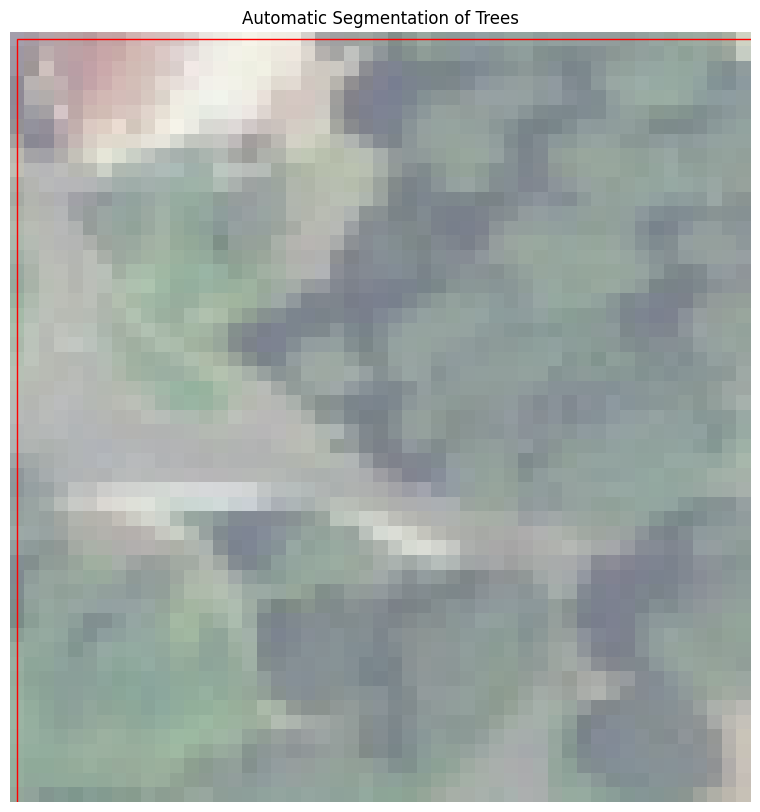

In [61]:
sam.show_anns(
    cmap="Greens",
    box_color="red",
    title="Automatic Segmentation of Trees",
    blend=True,
)

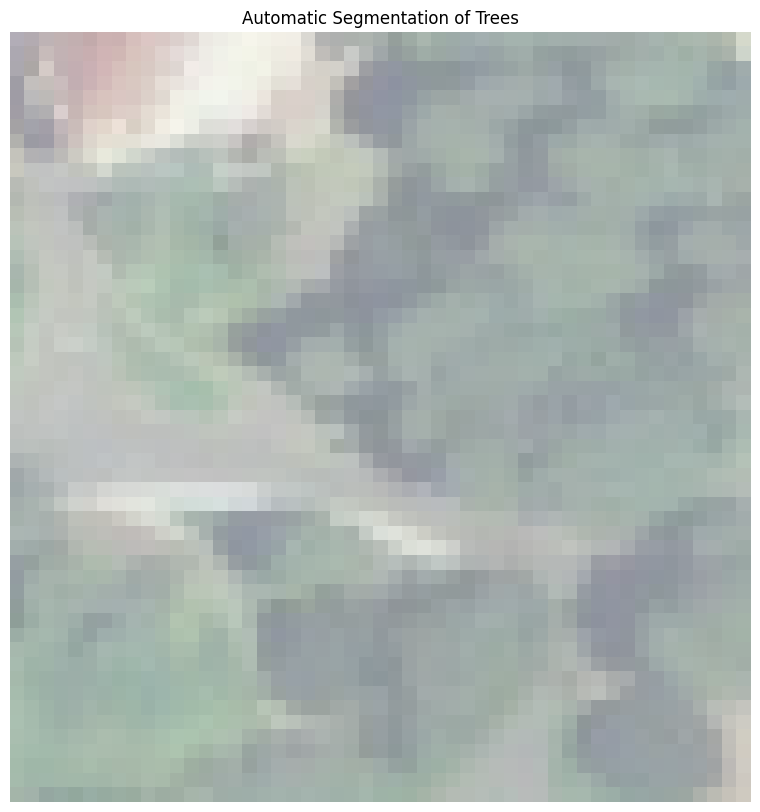

In [62]:
# Visualize the segmentation results
sam.show_anns(
    cmap="Greens",
    add_boxes=False,
    alpha=0.5,
    title="Automatic Segmentation of Trees"
)


In [63]:
# Add results to the map
m.add_raster(output_image, opacity=0.5, layer_name="Segmented Trees")
m

Map(bottom=6479336.0, center=[37.8716733616144, -122.26795566531358], controls=(WidgetControl(options=['positi…